# ML_25M Deep ML

In [1]:
import torch
import time
import os
import copy
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import itertools
from sklearn.metrics import r2_score, mean_squared_error

def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

fix_random(42)

In [2]:
df = pd.read_csv('dataset.csv')

# PyTorch Device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('Using device:', device)

Using device: mps


In [3]:
delete_previous = True

if delete_previous:
    try:
        os.system('rm -rf runs')
        os.system('rm -rf models')
        os.system('rm -rf best_model.pth')
        os.system('rm -rf best_model_config.json')
    except:
        pass

# Data preprocessing

In [4]:
X = df.drop('rating', axis=1)
Y = df['rating']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()
Y_train = Y_train.to_numpy()
Y_val = Y_val.to_numpy()
Y_test = Y_test.to_numpy()

In [5]:
# PCA
pca = PCA(n_components=0.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

In [6]:
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of validation samples: {X_val.shape[0]}')
print(f'Number of testing samples: {X_test.shape[0]}')
print(f'\nNumber of features: {X_train.shape[1]}')

val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.float32)), batch_size=Y_val.shape[0], shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32)), batch_size=Y_test.shape[0], shuffle=False)

Number of training samples: 9946
Number of validation samples: 1106
Number of testing samples: 2764

Number of features: 552


In [7]:
if os.path.isfile('results.csv'):
    results = pd.read_csv('results.csv')
else:
    results = pd.DataFrame(columns=['model', 'mse', 'r2'])

# Neural Network

In [8]:
def get_model(input_size, hidden_size, dropout_prob=0, depth=1):
    model = [
        torch.nn.Linear(input_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Dropout(dropout_prob)
    ]

    for i in range(depth):
        model.append(torch.nn.Linear(hidden_size, hidden_size))
        model.append(torch.nn.ReLU())
        model.append(torch.nn.Dropout(dropout_prob))

    model.append(torch.nn.Linear(hidden_size, 1))
    return torch.nn.Sequential(*model)


In [9]:
# hyperparameters
hidden_sizes =  [128, 256, 512, 1024]
nums_epochs = [200]
depth = [3, 4, 5]
batch_sizes = [32, 64, 128]
learning_rate = [0.1, 0.01]
step_size_lr_decay = [10, 20]
momentum = [0.9]
dropout_prob = 0.2
patience = 10

hyperparameters = itertools.product(hidden_sizes, depth, nums_epochs, batch_sizes, learning_rate, step_size_lr_decay, momentum)
n_comb = len(hidden_sizes)*len(depth)*len(nums_epochs)*len(batch_sizes)*len(learning_rate)*len(step_size_lr_decay)*len(momentum)
print (f'Number of hyperparameter combinations: {n_comb}')

Number of hyperparameter combinations: 108


In [10]:
def test_model(model, criterion, loader):
    loss = 0
    y_pred = torch.tensor([]).to(device)
    y_true = torch.tensor([]).to(device)
    i = 0

    for _, (x, y) in enumerate(loader):
        i += 1
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss += criterion(output.squeeze(), y)
        y_pred = torch.cat((y_pred, output), 0)
        y_true = torch.cat((y_true, y), 0)

    return loss /i, y_pred.squeeze(), y_true


In [11]:
# training process
def train_model(model, criterion, optimizer, scheduler, epochs, data_loader, val_loader, device, writer, log_name):
    n_iter = 0

    best_model = None
    best_val_loss = float('inf')
    epochs_since_last_improvement = 0

    start = time.time()

    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        model.train()

        start_epoch = time.time()

        loss_train = 0
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            y_pred = model(data)
            loss = criterion(y_pred.squeeze(), targets)
            optimizer.zero_grad()
            writer.add_scalar("Loss/train", loss, n_iter)
            loss.backward()
            optimizer.step()
            n_iter += 1
            loss_train += loss.item()

        scheduler.step()

        loss_train /= len(data_loader)
        

        # Compute Val Loss
        val_loss, _, _ = test_model(model, criterion, val_loader)
        writer.add_scalar("Loss/val", val_loss, epoch)

        loss_history.append(loss_train)
        val_loss_history.append(val_loss.item())

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            epochs_since_last_improvement = 0
        elif epochs_since_last_improvement >= patience:
            break
        else:
            epochs_since_last_improvement += 1

        print('Epoch [{}/{}] - {:.2f} seconds - val_loss: {:.6f} - patience: {}'.format(epoch+1,
              epochs, time.time() - start_epoch, val_loss, epochs_since_last_improvement), end='\r')

    print('\nTraining ended after {:.2f} seconds - Best val_loss: {:.6f}'.format(time.time() - start, best_val_loss))

    return best_model, loss_history, val_loss_history

In [12]:
current_iter = 0

best_model = None
best_mse = float('inf')
criterion = torch.nn.MSELoss()
history_loss = []
history_val_loss = []

if os.path.exists('best_model.pth'):
    # read best model config
    with open('best_model_config.json', 'r') as f:
        best_model_config = json.load(f)

    # load best model
    best_model = get_model(X_train.shape[1], best_model_config['hidden_size'], dropout_prob, best_model_config['depth'])
    best_model.load_state_dict(torch.load('best_model.pth'))
    best_model.to(device)
    best_model.eval()

    # evaluate best model
    best_mse, _, _ = test_model(best_model, criterion, test_loader)
    
    print("Best model - MSE: {:.6f}".format(best_mse))

if not os.path.exists('models'):
    os.makedirs('models')

for hidden_size, depth, num_epochs, batch, lr, step_size, momentum in hyperparameters:
    current_iter += 1

    print("\nIterations {}/{} - Training with hidden_size={}, depth={}, num_epochs={}, batch={}, lr={}, step_size={}, momentum={}".format(
        current_iter, n_comb, hidden_size, depth, num_epochs, batch, lr, step_size, momentum))
    
    log_name = "dim:"+str(hidden_size)+"_depth:"+str(depth)+"_batch:" + \
        str(batch)+"_lr:"+str(lr)+"_step_size:" + \
        str(step_size)

    if os.path.exists('runs/'+log_name):
        print("Model already trained, skipping...")
        continue

    # start tensorboard
    writer = SummaryWriter('runs/'+log_name)

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32)), batch_size=batch, shuffle=True)

    model = get_model(X_train.shape[1], hidden_size, dropout_prob, depth=depth)
    model = model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

    # train
    model, hl, hvl = train_model(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader, device, writer, log_name)

    # validate model on test set
    mse, _, _ = test_model(model, criterion, test_loader)
    writer.add_hparams({'hidden_size': hidden_size, 'depth': depth, 'batch': batch,'lr': lr, 'step_size': step_size, 'momentum': momentum}, {'hparam/mse': mse})

    if mse < best_mse:
        best_mse = mse
        best_model = model
        
        history_loss = hl
        history_val_loss = hvl

        torch.save(model.state_dict(), 'best_model.pth')
        # save config
        with open('best_model_config.json', 'w') as f:
            json.dump({'name':log_name,'hidden_size': hidden_size, 'depth': depth, 'num_epochs': num_epochs, 'batch': batch,
                       'lr': lr, 'step_size': step_size}, f)
            
            
    print("Model MSE: {:.6f} - Best MSE: {:.6f}".format(mse, best_mse))

    torch.save(model.state_dict(), 'models/'+log_name+'.pth')
    writer.flush()

writer.close()



Iterations 1/108 - Training with hidden_size=256, depth=3, num_epochs=200, batch=32, lr=0.1, step_size=10, momentum=0.9
Epoch [30/200] - 2.02 seconds - val_loss: 0.009590 - patience: 10
Training ended after 64.93 seconds - Best val_loss: 0.007861
Model MSE: 0.008527 - Best MSE: 0.008527

Iterations 2/108 - Training with hidden_size=256, depth=3, num_epochs=200, batch=32, lr=0.1, step_size=20, momentum=0.9
Epoch [56/200] - 2.31 seconds - val_loss: 0.009108 - patience: 10
Training ended after 131.35 seconds - Best val_loss: 0.008102
Model MSE: 0.008131 - Best MSE: 0.008131

Iterations 3/108 - Training with hidden_size=256, depth=3, num_epochs=200, batch=32, lr=0.01, step_size=10, momentum=0.9
Epoch [42/200] - 1.97 seconds - val_loss: 0.010883 - patience: 10
Training ended after 87.46 seconds - Best val_loss: 0.009863
Model MSE: 0.010735 - Best MSE: 0.008131

Iterations 4/108 - Training with hidden_size=256, depth=3, num_epochs=200, batch=32, lr=0.01, step_size=20, momentum=0.9
Epoch [45

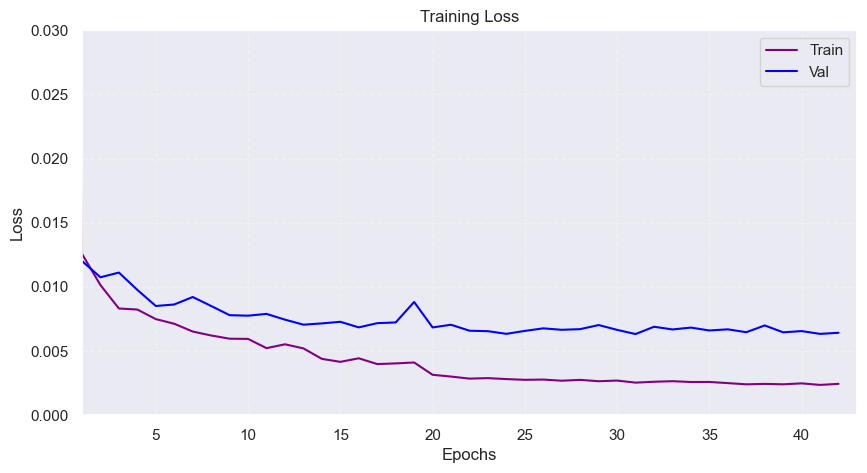

In [36]:
# # Plot loss
sns.set()
plt.figure(figsize=(10, 5))
plt.title("Training Loss")
plt.xlim(1, len(history_loss))
plt.ylim(0, 0.03)
plt.plot(history_loss, label="Train", color='purple')
plt.plot(history_val_loss, label="Val", color='blue')
plt.grid(True, zorder=1, linestyle='--', alpha=0.3)
plt.legend()
plt.legend(['Training', 'Validation'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Neural Network Evalutation

In [49]:
_, y_pred, y_true = test_model(best_model, criterion, test_loader)
y_pred = y_pred.cpu().detach().numpy()
y_true = y_true.cpu().detach().numpy()

In [82]:
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print("R2: {:.6f} - MSE: {:.6f}".format(r2, mse))

R2: 0.970828 - MSE: 0.006466


In [15]:
results = pd.concat([results, pd.DataFrame({'MSE': [mse], 'R2': [r2], 'Model': "deep_network"})]) 